# Tidy Data

---

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

Tidy Data (and the closely related topic of reshaping data) is a way of structuring your data and APIs in a consistent (sensible) way to make the data analysis process flow more smoothly.

## The Rules

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks", context="talk")
plt.rcParams['figure.figsize'] = 12, 8
pd.options.display.max_rows = 10
%matplotlib inline

## NBA Games

Earlier, I fetched some data

```python
tables = pd.read_html(
  "http://www.basketball-reference.com/leagues/"
  "NBA_2016_games.html"
)
games = tables[0]
games.to_csv('data/games.csv', index=False)
```

In [2]:
!head -n  5 data/games.csv

Date,Start (ET),Unnamed: 2,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 7,Notes
October,,,,,,,,
"Tue, Oct 27, 2015",8:00 pm,Box Score,Detroit Pistons,106.0,Atlanta Hawks,94.0,,
"Tue, Oct 27, 2015",8:00 pm,Box Score,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,,
"Tue, Oct 27, 2015",10:30 pm,Box Score,New Orleans Pelicans,95.0,Golden State Warriors,111.0,,


So the data is roughly like

| Date        | Visitor Team | Visitor Points | Home Team | Home Points |
| ----------- | ------------ | -------------- | --------- | ----------- |
| 2015-10-07  | Detroit      | 106            | Atlanta   | 94          |
| ...         | ...          | ...            | ...       | ...         |

Plus some extra junk we don't really care about.

## [The Question](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows):

> **How many days of rest did each team get between each game?**

Whether or not your dataset is tidy depends on your question. Given our question, Is our data tidy?

What should the columns (variables) be?

What's an observation?

<a href="#answer" class="btn btn-default" data-toggle="collapse">Show Answer</a>
<div id="answer" class="collapse">
An observation is a (team, game) pair. So no, we don't have a tidy dataset.
A tidy dataset would be like

<table>
<thead>
<tr class="header">
<th>Date</th>
<th>Team</th>
<th>Home / Away</th>
<th>Points</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>2015-10-07</td>
<td>Detroit</td>
<td>Away</td>
<td>106</td>
</tr>
<tr class="even">
<td>2015-10-07</td>
<td>Atlanta</td>
<td>Home</td>
<td>94</td>
</tr>
<tr class="odd">
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</tbody>
</table>

</div>

Let's do a bit of general cleaning to remove that extra junk before reshaping the data to be tidy.

In [3]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

keep = ['date', 'away_team', 'away_points', 'home_team', 'home_points']

games = (
    pd.read_csv("data/games.csv")
      .rename(columns=column_names)
      .dropna(thresh=4)                  # Drop rows with >= 4 missing values
      [keep]
      .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
      .set_index('date', append=True)    # Move the 'date' col to the index
      .rename_axis(["game_id", "date"])  # Change the `.index.names` list
      .sort_index()
)
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0


Above, we saw that we need to collapse the away / home teams down to two columns: one identifier and one for the value.
Likewise with the points.
We'll also need to repeat the metadata fields, like the date and `game_id`, so that each observation is matched with the correct date.
`pd.melt` does all this for us.

## Melt

![melt](figures/melt.png)

- Collect a variable spread across multiple columns into one, but
- Repeat the metadata to stay with each observation

In [4]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team', var_name='home_away').sort_values(['game_id', 'date'])

tidy.head()

,game_id,date,home_away,team
0,1,2015-10-27,away_team,Detroit Pistons
1230,1,2015-10-27,home_team,Atlanta Hawks
1,2,2015-10-27,away_team,Cleveland Cavaliers
1231,2,2015-10-27,home_team,Chicago Bulls
2,3,2015-10-27,away_team,New Orleans Pelicans


Now the translation from question to operation is direct:

In [5]:
# How many days of rest for each team?
# For each team...  get number of days between games
tidy.groupby('team').date.diff().dt.days - 1

0       NaN
1230    NaN
1       NaN
1231    NaN
2       NaN
       ... 
2457    1.0
1228    2.0
2458    3.0
1229    1.0
2459    1.0
Name: date, Length: 2460, dtype: float64

We haven't seen `.diff` yet. It takes the value in the current row minus the value in the previous. Since `.date` is a `datetime`, the result is a `timedelta`. Timedeltas have that special `.dt` namespace for accessing properties of each timedelta, like the number of days.

In [6]:
# Assign tidy['rest']
tidy['rest'] = tidy.groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,home_away,team,rest
4,5,2015-10-28,away_team,Chicago Bulls,0.0
1235,6,2015-10-28,home_team,Detroit Pistons,0.0
8,9,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,15,2015-10-28,away_team,New Orleans Pelicans,0.0
17,18,2015-10-29,away_team,Memphis Grizzlies,0.0


## `pivot_table`

You can "invert" a `melt` with `pd.pivot_table`

In [7]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='home_away')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'})
             .rename_axis(None, axis='columns'))
by_game.dropna().head()

,,away_rest,home_rest
game_id,date,,
18,2015-10-29,0.0,0.0
19,2015-10-29,0.0,0.0
20,2015-10-29,1.0,0.0
21,2015-10-30,1.0,0.0
22,2015-10-30,1.0,1.0


`concat` will merge the two dataframes (`games, by_game`), expanding an `axis`, while aligning on the other axis.

In [8]:
df = pd.concat([games, by_game], axis='columns')
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
18,2015-10-29,Memphis Grizzlies,112.0,Indiana Pacers,103.0,0.0,0.0
19,2015-10-29,Dallas Mavericks,88.0,Los Angeles Clippers,104.0,0.0,0.0
20,2015-10-29,Atlanta Hawks,112.0,New York Knicks,101.0,1.0,0.0
21,2015-10-30,Charlotte Hornets,94.0,Atlanta Hawks,97.0,1.0,0.0
22,2015-10-30,Toronto Raptors,113.0,Boston Celtics,103.0,1.0,1.0


## Two datasets

- `tidy`: For team-level questions
- `df`: For game-level questions

Even though I called one of the variables `tidy`, both datasets are tidy in their own way, it just depends on the question your trying to answer.

For example, let's say we wanted to look at the rest durations, split by home/away, faceted by team. We'd use `tidy` for that since it's a team-level question. We'll facet by `team` (wrapping the columns so it doesn't get too wide. And `map` a barplot with `x=variable` and `y=rest`.

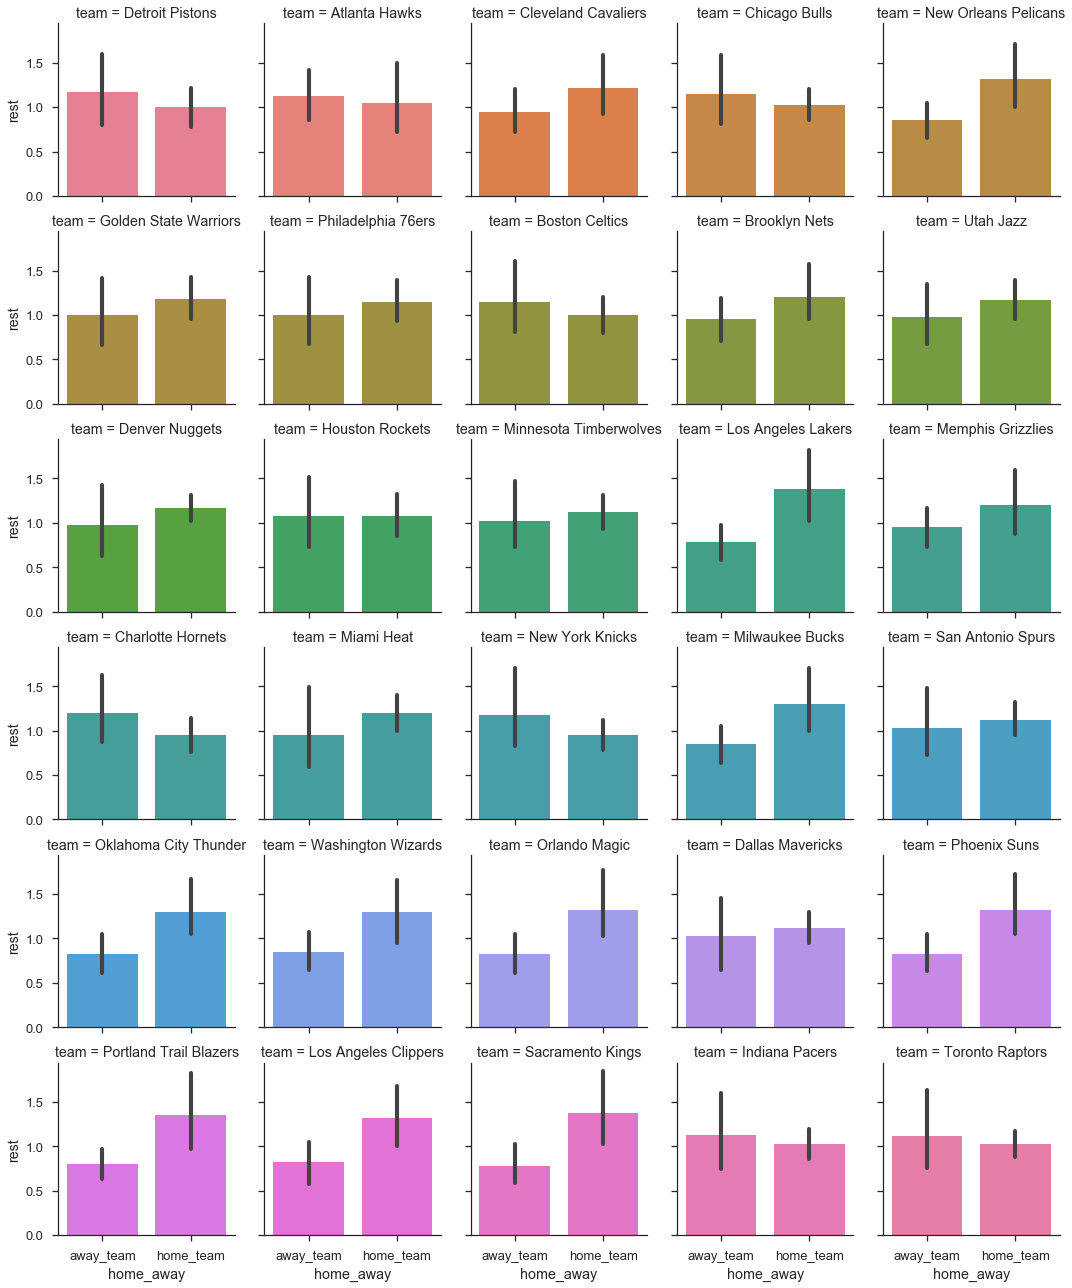

In [9]:
g = sns.FacetGrid(tidy, col="team", col_wrap=5, hue="team")
g.map(sns.barplot, "home_away", "rest", order=['away_team', 'home_team']);

If we wanted to look at the distribution of the *differences* in rest, we'd use `df` since the difference is a game-level statistic.

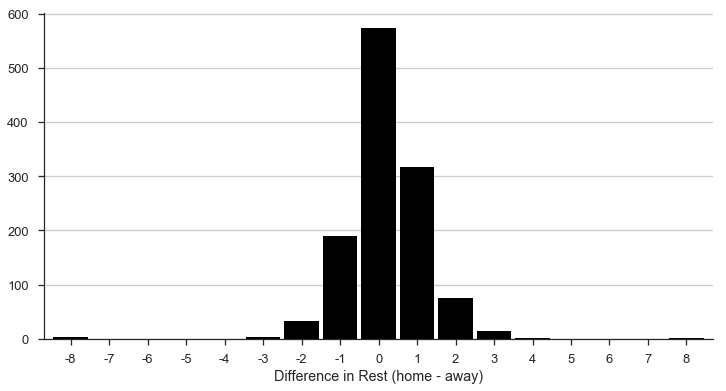

In [10]:
delta = (df['home_rest'] - df['away_rest']).dropna().astype(int)
(delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index().plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6)))

sns.despine()
plt.xlabel("Difference in Rest (home - away)")
plt.grid(axis='y');

<div class="alert alert-success" data-title="Win Percent">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Win Percent</h1>
</div>

<p>Find the win-percent for each team, by whether they're home or away.</p>

Hints:

- You'll need a new variable in `df` called `winning_team` (use `np.where`?). That should have the name of the winning team
- You'll need to `melt` that along with the home / away columns (which column is `id_vars`? Which columns are `value_vars`?)
- A tidy dataset looks like

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>winning_team</th>
      <th>home_or_away</th>
      <th>team</th>
      <th>won</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Detroit Pistons</td>
      <td>away_team</td>
      <td>Detroit Pistons</td>
      <td>True</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Chicago Bulls</td>
      <td>away_team</td>
      <td>Cleveland Cavaliers</td>
      <td>False</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Golden State Warriors</td>
      <td>away_team</td>
      <td>New Orleans Pelicans</td>
      <td>False</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Boston Celtics</td>
      <td>away_team</td>
      <td>Philadelphia 76ers</td>
      <td>False</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Chicago Bulls</td>
      <td>away_team</td>
      <td>Chicago Bulls</td>
      <td>True</td>
    </tr>
  </tbody>
</table>

- With the tidy dataset we can `groupby` and take the mean. Teams play the same number of home and away games, so a simple (un-weighted) average will work.

In [ ]:
df['winning_team'] = np.where(
    ...  # the condition
    ...  # pick from this array if condition is true
    ...  # pick from this array if condition is false
)

win = pd.melt(
    df,
    id_vars=...,
    value_vars=...
    var_names='home_or_away',
    value_name='team'
)

win['won'] = ... # True when the `winning_team` equals `team`
win_pct = ...    # win percent for each team, by home or away. Sounds like a groupby.

In [12]:
%load solutions/tidy_00.py

team            home_or_away
Atlanta Hawks   away_team       0.512195
                home_team       0.658537
Boston Celtics  away_team       0.487805
                home_team       0.682927
Brooklyn Nets   away_team       0.170732
Name: won, dtype: float64

## Stack / Unstack

- stack: `DataFrame` -> `Series` with `MultiIndex`
- unstack: `Series` with `MultiIndex` -> `DataFrame`

The exact shape of a tidy dataset depends on the question being asked.
Additionally, not all APIs expect tidy data, so you need to convert between "wide" and "long" form data.

Let's create a `rest` varible that's the average `rest` by `home_away` and `date` across teams:

In [13]:
rest = tidy.groupby(['home_away', 'date']).rest.mean()
rest.head()

home_away  date      
away_team  2015-10-27         NaN
           2015-10-28    0.000000
           2015-10-29    0.333333
           2015-10-30    1.083333
           2015-10-31    0.166667
Name: rest, dtype: float64

`rest` is in "long" form. `DataFrame.plot` for example, expects wide form data, so use `.unstack`

In [14]:
rest.unstack('home_away').head()

home_away,away_team,home_team
date,,
2015-10-27,NaN,NaN
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


And we can plot the rolling mean:

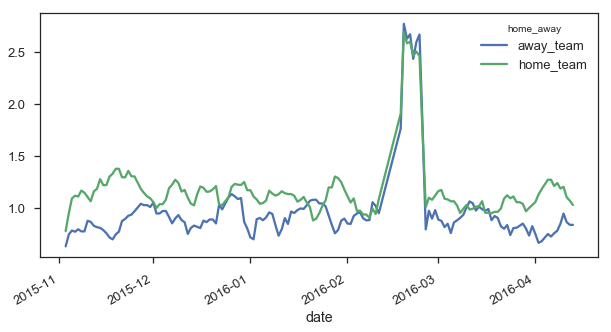

In [15]:
rest.unstack('home_away').rolling(7).mean().plot(figsize=(10, 5));

Stack and unstack are inverses:

In [16]:
rest.unstack("home_away").stack().head()

date        home_away
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
dtype: float64

<div class="alert alert-success" data-title="Home Court Advantage?">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Home Court Advantage?</h1>
</div>
<p>How much of home court advantage can be explained by rest?</p>

Reproducing [this](http://www.nessis.org/nessis07/Dylan_Small.pdf).
Basically, we want to run a regression of

    point_spread ~ rest_spread + other_stuff

We'll talk about the `other_stuff` later when we get to it.
For now, we need to augment `df` with a couple additional varibles.

If your DataFrame is out of sync, you might want to load in a fresh one, by copying this code into a new cell and running it.

```python
df = pd.read_csv('data/tidy_checkpoint.csv', parse_dates=['date'],
                 index_col=['game_id', 'date'])
```

## Step 0: Outcome variables

Modify `df` to include a couple potential targets

- `point_spread`: the home score minus the away score
- `home_win`: binary indicator for whether the home team won

In [ ]:
df['point_spread'] = ...
df['home_win'] = df['point_spread'] ...

In [19]:
%load solutions/tidy_01.py


,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,point_spread,home_win
game_id,date,,,,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN,Detroit Pistons,-12.0,False
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN,Chicago Bulls,2.0,True
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN,Golden State Warriors,16.0,True
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN,Boston Celtics,17.0,True
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN,Chicago Bulls,-15.0,False


## Step 1: Team Strength

Most examples I've seen use a "team strength" variable in their regression estimating the home court advantage. We'll grab one from ESPN.

Use RPI from prior year: http://www.espn.com/nba/stats/rpi/_/year/2015 as a measure of team strength

```python
rpi = pd.read_html("http://www.espn.com/nba/stats/rpi/_/year/2015")[0]
```

In [20]:
raw_rpi = pd.read_csv("data/rpi.csv")
raw_rpi.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2014-15 NBA RPI Rankings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RK,TEAM,RPI,W,L,PCT,SOS,PWR,PF,PA,EWL,EWP
2,1,Golden State,.582,67,15,.817,.504,1,9016,8188,68-14,.831
3,2,Houston,.552,56,26,.683,.509,7,8522,8240,52-30,.635
4,NaN,LA,.552,56,26,.683,.509,4,8751,8211,61-21,.741


In [21]:
rpi_cols = raw_rpi.loc[1]
rpi = (
    raw_rpi.drop([0, 1])
       .rename(columns={str(i): v for i, v in enumerate(rpi_cols)})
       .set_index("TEAM")
       .assign(RPI=lambda x: pd.to_numeric(x.RPI))
)
rpi.head()

,RK,RPI,W,L,PCT,SOS,PWR,PF,PA,EWL,EWP
TEAM,,,,,,,,,,,
Golden State,1,0.582,67,15,.817,.504,1,9016,8188,68-14,.831
Houston,2,0.552,56,26,.683,.509,7,8522,8240,52-30,.635
LA,NaN,0.552,56,26,.683,.509,4,8751,8211,61-21,.741
Atlanta,4,0.551,60,22,.732,.491,5,8409,7964,58-24,.710
Memphis,5,0.549,55,27,.671,.509,8,8062,7796,52-30,.635


Merge `df` and `rpi` on team. One uses just the city, while the other uses the city and team name.
Fortunately, both versions have the same sort order, so we're able to unambigusly map `<city>` to `<city> <team>`.

In [22]:
mapping = dict(zip(
    sorted(rpi.index),
    sorted(set(df.away_team.unique()))
))
mapping

{'Atlanta': 'Atlanta Hawks',
 'Boston': 'Boston Celtics',
 'Brooklyn': 'Brooklyn Nets',
 'Charlotte': 'Charlotte Hornets',
 'Chicago': 'Chicago Bulls',
 'Cleveland': 'Cleveland Cavaliers',
 'Dallas': 'Dallas Mavericks',
 'Denver': 'Denver Nuggets',
 'Detroit': 'Detroit Pistons',
 'Golden State': 'Golden State Warriors',
 'Houston': 'Houston Rockets',
 'Indiana': 'Indiana Pacers',
 'LA': 'Los Angeles Clippers',
 'LA Lakers': 'Los Angeles Lakers',
 'Memphis': 'Memphis Grizzlies',
 'Miami': 'Miami Heat',
 'Milwaukee': 'Milwaukee Bucks',
 'Minnesota': 'Minnesota Timberwolves',
 'New Orleans': 'New Orleans Pelicans',
 'New York': 'New York Knicks',
 'Oklahoma City': 'Oklahoma City Thunder',
 'Orlando': 'Orlando Magic',
 'Philadelphia': 'Philadelphia 76ers',
 'Phoenix': 'Phoenix Suns',
 'Portland': 'Portland Trail Blazers',
 'Sacramento': 'Sacramento Kings',
 'San Antonio': 'San Antonio Spurs',
 'Toronto': 'Toronto Raptors',
 'Utah': 'Utah Jazz',
 'Washington': 'Washington Wizards'}

Create two new columns in `df`

- `home_strength`
- `away_strength`

Using either `.map` or `pd.merge` and the `mapping` varaible we just created.
The strength columns should contain the `RPI` for the home / away team from `rpi`.

We need to go from

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>RPI</th>
    </tr>
    <tr>
      <th>TEAM</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Golden State</th>
      <td>0.582</td>
    </tr>
    <tr>
      <th>Houston</th>
      <td>0.552</td>
    </tr>
  </tbody>
</table>

to

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>RPI</th>
    </tr>
    <tr>
      <th>TEAM</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Golden State Warriors</th>
      <td>0.582</td>
    </tr>
    <tr>
      <th>Houston Rockets</th>
      <td>0.552</td>
    </tr>
  </tbody>
</table>

to

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>home_team</th>
      <th>away_team</th>
      <th>home_strength</th>
      <th>away_strength</th>
    </tr>
    <tr>
      <th>game_id</th>
      <th>date</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <th>2015-10-27</th>
      <td>Atlanta Hawks</td>
      <td>Detroit Pistons</td>
      <td>0.551</td>
      <td>0.467</td>
    </tr>
    <tr>
      <th>2</th>
      <th>2015-10-27</th>
      <td>Chicago Bulls</td>
      <td>Cleveland Cavaliers</td>
      <td>0.523</td>
      <td>0.535</td>
    </tr>
  </tbody>
</table>

In [23]:
city_rpi = rpi.RPI.rename(mapping)
city_rpi

TEAM
Golden State Warriors     0.582
Houston Rockets           0.552
Los Angeles Clippers      0.552
Atlanta Hawks             0.551
Memphis Grizzlies         0.549
                          ...  
Orlando Magic             0.447
Los Angeles Lakers        0.444
Minnesota Timberwolves    0.430
Philadelphia 76ers        0.425
New York Knicks           0.419
Name: RPI, Length: 30, dtype: float64

In [ ]:
df['home_strength'] = df.home_team.map(...)
df['away_strength'] = ...

In [25]:
%load solutions/tidy_02.py

,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,point_spread,home_win,home_strength,away_strength
game_id,date,,,,,,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN,Detroit Pistons,-12.0,False,0.551,0.467
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN,Chicago Bulls,2.0,True,0.523,0.535
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN,Golden State Warriors,16.0,True,0.582,0.517
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN,Boston Celtics,17.0,True,0.490,0.425
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN,Chicago Bulls,-15.0,False,0.487,0.523


## Step 2: Rest Difference

Create a new column `rest_spread` that contains the difference in rest (home - away)

In [27]:
%load solutions/tidy_03.py


,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,point_spread,home_win,home_strength,away_strength,rest_spread
game_id,date,,,,,,,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN,Detroit Pistons,-12.0,False,0.551,0.467,NaN
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN,Chicago Bulls,2.0,True,0.523,0.535,NaN
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN,Golden State Warriors,16.0,True,0.582,0.517,NaN
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN,Boston Celtics,17.0,True,0.490,0.425,NaN
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN,Chicago Bulls,-15.0,False,0.487,0.523,NaN


Remove rows with missing values (rest), fixup a dtype for statsmodels

In [28]:
df = df.dropna().copy()
df.loc[:, 'home_win'] = df['home_win'].astype(int)
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,point_spread,home_win,home_strength,away_strength,rest_spread
game_id,date,,,,,,,,,,,,
18,2015-10-29,Memphis Grizzlies,112.0,Indiana Pacers,103.0,0.0,0.0,Memphis Grizzlies,-9.0,0,0.484,0.549,0.0
19,2015-10-29,Dallas Mavericks,88.0,Los Angeles Clippers,104.0,0.0,0.0,Los Angeles Clippers,16.0,1,0.552,0.536,0.0
20,2015-10-29,Atlanta Hawks,112.0,New York Knicks,101.0,1.0,0.0,Atlanta Hawks,-11.0,0,0.419,0.551,-1.0
21,2015-10-30,Charlotte Hornets,94.0,Atlanta Hawks,97.0,1.0,0.0,Atlanta Hawks,3.0,1,0.551,0.471,-1.0
22,2015-10-30,Toronto Raptors,113.0,Boston Celtics,103.0,1.0,1.0,Toronto Raptors,-10.0,0,0.490,0.517,0.0


## Step 3: Sanity Check

Let's do some checks to see if we're on the right track.
Does the home team typically have more rest? What's the average difference in rest?

In [30]:
%load solutions/tidy_drest.py


0.19455894476504534

What's the relationship between the difference in rest and home win percent? I did a barplot, but you can explore it however you want.

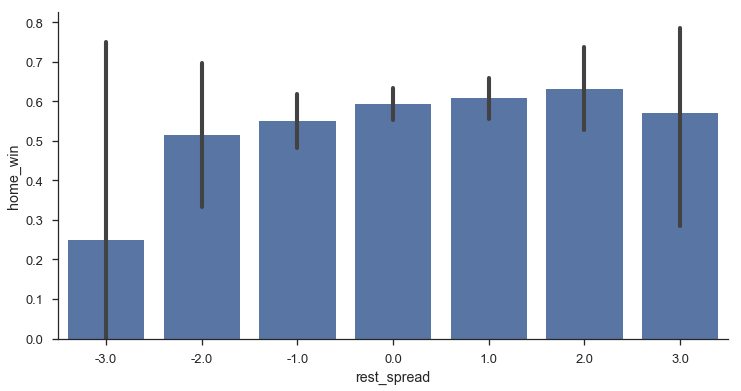

In [32]:
%load solutions/tidy_04.py


We can plot each team's win percent by home or away:

/Users/taugspurger/miniconda3/envs/ph2t2/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


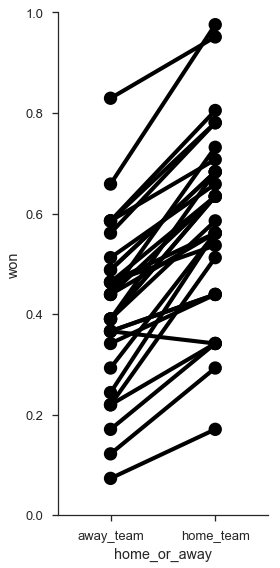

In [33]:
g = sns.FacetGrid(win_pct.reset_index(), hue='team', size=8, aspect=.5, palette=['k'])
g.map(sns.pointplot, 'home_or_away', 'won').set(ylim=(0, 1));

## Step 4: Regression

Now we can fit the model using statsmodels

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/taugspurger/miniconda3/envs/ph2t2/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,point_spread,home_win,home_strength,away_strength,rest_spread
game_id,date,,,,,,,,,,,,
18,2015-10-29,Memphis Grizzlies,112.0,Indiana Pacers,103.0,0.0,0.0,Memphis Grizzlies,-9.0,0,0.484,0.549,0.0
19,2015-10-29,Dallas Mavericks,88.0,Los Angeles Clippers,104.0,0.0,0.0,Los Angeles Clippers,16.0,1,0.552,0.536,0.0
20,2015-10-29,Atlanta Hawks,112.0,New York Knicks,101.0,1.0,0.0,Atlanta Hawks,-11.0,0,0.419,0.551,-1.0
21,2015-10-30,Charlotte Hornets,94.0,Atlanta Hawks,97.0,1.0,0.0,Atlanta Hawks,3.0,1,0.551,0.471,-1.0
22,2015-10-30,Toronto Raptors,113.0,Boston Celtics,103.0,1.0,1.0,Toronto Raptors,-10.0,0,0.490,0.517,0.0


In [36]:
mod = smf.ols('point_spread ~ rest_spread + home_strength + away_strength', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           point_spread   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     54.28
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           6.48e-33
Time:                        11:18:58   Log-Likelihood:                -4783.6
No. Observations:                1213   AIC:                             9575.
Df Residuals:                    1209   BIC:                             9596.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.5106      6.147     -1.059      0.290     -18.571       5.550
rest_spread       0.3939      0.341      1.155      0.248      -0.275       1.063
home_strength    85.5022      8.604      9.938      0.000      68.622     102.382
away_strength   -67.1119      8.617     -7.789      0.000     -84.017     -50.207
==============================================================================
Omnibus:                        6.326   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                7.183
Skew:                           0.093   Prob(JB):                       0.0276
Kurtosis:                       3.328   Cond. No.                         37.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So an extra day of rest is worth between -.28 and 1.06 points. Not that impresssive.

## Road Trips

Do teams on longer road trips perform less well?
Basically, what is the probability of winning as a function of number of *consecutive* games on the road?

We'll need to compute an `away_streak` variable that contains the number of consecutive away games.
This will reset to 0 each time the team returns home.
For example:

home_away  | away_streak
---------- | -----------
H          | 0
A          | 1
A          | 2
H          | 0
A          | 1
A          | 2
A          | 3

This will need to be done in the context of a `groupby`.
When developing complicated groupby functions, I like to grab and individual group and prototype on that:

In [37]:
gr = tidy.groupby('team').home_away
v = gr.get_group("Chicago Bulls")  # Use `.get_group` to extract a single group
v.head()

1231    home_team
4       away_team
24      away_team
1269    home_team
52      away_team
Name: home_away, dtype: object

This is an example of a computation that's difficult (though not impossible) to vectorize.
The relative simplicity of the iterative solution (like the skeleton below) outweighs the performance cost.

Fill in the ellipses (`...`) below.

In [37]:
import unittest
import pandas.util.testing as tm


def compute_away_streaks(v):
    # streaks will contain one entry per game.
    streaks = []
    current_streak = 0

    for row in v:
        if row == 'away_team':
            ...  # what happens here?
        else:
            # The team is playing at home. What should the
            # away streak be here?
            current_streak = ...
        streaks.append(streak)  # add to the container

    streaks = pd.Series(streaks, index=v.index)
    return streaks


class TestAwayStreak(unittest.TestCase):
    maxDiff = None

    def test_compute_streaks(self):
        result = compute_away_streaks(v).head(10)  # easier to check
        expected = pd.Series([0, 1, 2, 0, 1, 0, 0, 1, 0, 0],
                             index=[1231, 4, 24, 1269, 52, 1299, 1315, 103, 1357, 1381])

        tm.assert_series_equal(result, expected)

suite = unittest.TestLoader().loadTestsFromModule(TestAwayStreak())
unittest.TextTestRunner().run(suite)

E
ERROR: test_compute_streaks (__main__.TestAwayStreak)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-37-46ec53f2abbe>", line 25, in test_compute_streaks
    result = compute_away_streaks(v).head(10)  # easier to check
  File "<ipython-input-37-46ec53f2abbe>", line 15, in compute_away_streaks
    streaks.append(streak)  # add to the container
NameError: name 'streak' is not defined

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


<unittest.runner.TextTestResult run=1 errors=1 failures=0>

In [39]:
%load solutions/tidy_05.py

Now let's put `compute_away_streaks` to use. Before looking at the next cell, can you tell which `groupby` method we want to use? Recall that it can be

- `.agg`: one output row per group
- `.transform`: one output row per input row (same shape)
- `.apply`: arbitrary output shape

In this case it will be a `.transform`

In [40]:
streaks = tidy.groupby("team").home_away.transform(compute_away_streaks).astype(int)
tidy['away_streak'] = streaks
tidy.head()

,game_id,date,home_away,team,rest,away_streak
0,1,2015-10-27,away_team,Detroit Pistons,NaN,1
1230,1,2015-10-27,home_team,Atlanta Hawks,NaN,0
1,2,2015-10-27,away_team,Cleveland Cavaliers,NaN,1
1231,2,2015-10-27,home_team,Chicago Bulls,NaN,0
2,3,2015-10-27,away_team,New Orleans Pelicans,NaN,1


We need that `.astype` since currently `.transform` always returns the same dtype as the input (`object` in this case). There's an open pull request to fix that.

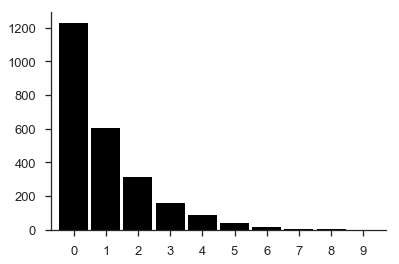

In [41]:
streaks.value_counts().plot.bar(color='k', width=.9, rot=0)
sns.despine();

And let's go from `tidy` to our game-level data with another `pivot_table`

In [42]:
game_away_streak = (
    pd.pivot_table(
        tidy, values='away_streak', index=['game_id', 'date'],
        columns='home_away'
    ).rename(columns={'away_team': 'away_streak'}))['away_streak']
df['game_away_streak'] = game_away_streak

A quick sanity check, and it doesn't seem like there's much to the hypothesis:

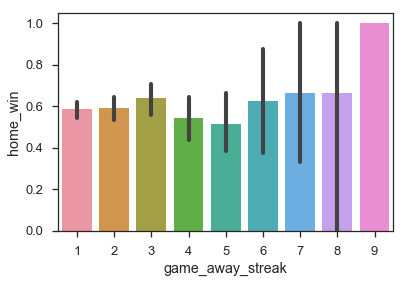

In [43]:
sns.barplot('game_away_streak', 'home_win', data=df);

If teams actually performed worse the longer they were on the road, we'd expect gradually declining bars.
Still, we can run the regression:

In [44]:
m = smf.ols("point_spread ~ rest_spread + game_away_streak + home_strength + away_strength", df)
res = m.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           point_spread   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     40.99
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           3.01e-32
Time:                        11:19:12   Log-Likelihood:                -4783.1
No. Observations:                1213   AIC:                             9576.
Df Residuals:                    1208   BIC:                             9602.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.0447      6.168     -1.142      0.254     -19.146       5.056
rest_spread          0.3825      0.341      1.121      0.262      -0.287       1.052
game_away_streak     0.2947      0.280      1.054      0.292      -0.254       0.843
home_strength       85.5030      8.604      9.938      0.000      68.623     102.382
away_strength      -67.2074      8.617     -7.800      0.000     -84.113     -50.302
==============================================================================
Omnibus:                        6.437   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                7.219
Skew:                           0.100   Prob(JB):                       0.0271
Kurtosis:                       3.320   Cond. No.                         76.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, there doesn't seem to be much to the "away streak" hypothesis. The upper bound of the 95% CI is less than 1 point for each additional consecutive game on the road.

## Recap

- Tidy data:
    - one variable per column
    - one row per observation
- Methods:
    - melt / stack: wide to long
    - pivot_table / unstack: long to wide